In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    return distance, pec_vel, temp, HI_density
def unPackDenFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    neutral_fraction = y[:,1]
    gas_density  = y[:,2]
    temperature = y[:,3]
   
    return distance, neutral_fraction,gas_density,temperature

In [3]:
def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    return gamma

In [4]:
sigma = 6.3e-18

In [21]:
# neutral fraction is defined with the old peak finder, the new finder neutral fraction is different. want to look at why the low ones are weird.
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    count = 0
    neutral_fraction_limit = 1e-3
    lyman_limited_value = []
    fraction = []
    gamma = []
    gas_density_normalized =[]
    HI = []
    checkout = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        den_path =  'los.00' + '{0:03}'.format(i) +'.den'
        distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance1,neutral_fraction1,gas_density1,temperature1 = unPackDenFile(den_path)
        distance_cm = distance *0.1453*3.086e24 /0.68
        gas_density =sp.interpolate.interp1d(distance1,gas_density1, fill_value="extrapolate")(distance)
        neutral_fraction = sp.interpolate.interp1d(distance1,neutral_fraction1, fill_value="extrapolate")(distance)
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k
                peak_fraction = neutral_fraction[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_density = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k+1
                        k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = neutral_fraction[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_density = gas_density[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (10**16)and area_under  <= (10**22) and area_under*sigma <1 and peak_fraction > 10**-(2.5)):
                        checkout.append([i,peak_distance,left_bases, right_bases, area_under*sigma, peak_fraction])
                    if(area_under >= (10**16)and area_under  <= (10**22) ):
                        lyman_limited_value.append(area_under)
                        fraction.append(peak_fraction)
                        gas_density_normalized.append(peak_density)
                        HI.append(peak_HI)
                        gamma.append(calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1453))
    return lyman_limited_value,fraction,gamma,gas_density_normalized,HI,checkout
lyman_limited_value,neutral_fraction,gamma,gas_density_normalized,HI,checkout= lyman_identification()


In [65]:
# neutral fraction is defined with the old peak finder, the new finder neutral fraction is different. want to look at why the low ones are weird.
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    count = 0
    neutral_fraction_limit = 1e-3
    lyman_limited_value = []
    fraction = []
    gamma = []
    gas_density_normalized =[]
    HI = []
    checkout = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        den_path =  'los.00' + '{0:03}'.format(i) +'.den'
        distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance1,neutral_fraction1,gas_density1,temperature1 = unPackDenFile(den_path)
        distance_cm = distance *0.1453*3.086e24 /0.68
        gas_density =sp.interpolate.interp1d(distance1,gas_density1, fill_value="extrapolate")(distance)
        neutral_fraction = sp.interpolate.interp1d(distance1,neutral_fraction1, fill_value="extrapolate")(distance)
        for k in range(len(distance) -2):
            if(neutral_fraction[k]<neutral_fraction_limit and neutral_fraction[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = neutral_fraction[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_density = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(neutral_fraction[k]>neutral_fraction_limit and neutral_fraction[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k+1
                        k+=1
                        if(neutral_fraction[k]>peak_fraction):
                            peak_fraction = neutral_fraction[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_density = gas_density[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (10**16)and area_under  <= (10**22)):
                        checkout.append([i,peak_distance,distance[left_bases], distance[right_bases], area_under*sigma, peak_fraction])
                    if(area_under >= (10**16)and area_under  <= (10**22) ):
                        lyman_limited_value.append(area_under)
                        fraction.append(peak_fraction)
                        gas_density_normalized.append(peak_density)
                        HI.append(peak_HI)
                        gamma.append(calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1453))
    return lyman_limited_value,fraction,gamma,gas_density_normalized,HI,checkout
lyman_limited_value,neutral_fraction,gamma,gas_density_normalized,HI,checkout= lyman_identification()


In [66]:
len(neutral_fraction)

1901

In [67]:
len(lyman_limited_value)

1901

In [68]:
checkout

[[1, 21.37743, 21.31825, 21.4288, 0.6929836256653129, 0.5882],
 [5, 25.60724, 25.57799, 25.64894, 0.07888861569370272, 0.07544],
 [7, 94.06673, 94.05204, 94.10785, 0.28022263115546875, 0.2414],
 [8, 45.33602, 45.31811, 45.3775, 0.09377572313451572, 0.04708],
 [10, 10.40144, 10.34988, 10.42437, 0.9380087915364906, 0.3664],
 [12, 58.54601, 58.53296, 58.57595, 0.0958289444316061, 0.2395],
 [13, 72.35725, 72.34326, 72.39118, 0.11860452567612798, 0.08503],
 [14, 3.15446, 3.14129, 3.19679, 0.5183484934367757, 0.01718],
 [14, 58.88882, 58.87639, 58.9312, 0.27750913581585596, 0.5576],
 [16, 65.98918, 65.97214, 66.03597, 0.4564099338591741, 0.02744],
 [17, 29.12628, 29.10856, 29.1987, 0.8592494015131859, 0.3524],
 [17, 64.61164, 64.59843, 64.63771, 0.17224576465065755, 0.07133],
 [17, 84.74833, 84.73345, 84.79238, 0.09238344726852256, 0.361],
 [19, 8.17074, 8.15121, 8.22934, 0.48525743760092466, 0.1331],
 [23, 3.72839, 3.70694, 3.76913, 0.3529079271939578, 0.006503],
 [23, 4.41293, 4.40278, 4.4

In [69]:
omega_b = 0.0479; h = 0.6814; scale = 0.1453
mean_nb = 1.123e-5/scale**3*omega_b*h**2
nb = np.multiply(gas_density_normalized,mean_nb*1.674e-24)

In [70]:
omega_b = 0.0479; h = 0.6814; scale = 0.1453
mean_nb = 1.123e-5/scale**3*omega_b*h**2

In [71]:
mean_nb

8.141842281358946e-05

In [72]:
nb

array([2.18888870e-31, 1.11502481e-30, 2.05532015e-31, ...,
       4.16106925e-31, 1.34917866e-31, 2.45193697e-31])

In [73]:
optical_depth = np.multiply(sigma,lyman_limited_value)

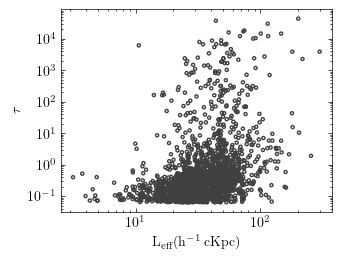

In [74]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("$\mathrm{L_{eff}(h^{-1}\:cKpc)}$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(np.multiply(np.divide(lyman_limited_value,HI),3.24078e-22/0.1453*0.68),optical_depth,s = 5,facecolors='none', edgecolors="0.25")
    plt.savefig('f4_uniform_40_L_eff.pdf') 

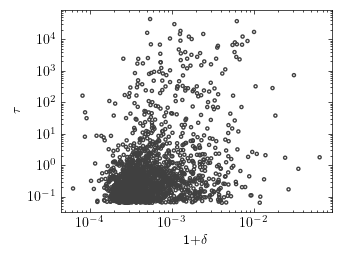

In [75]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("1+$\delta$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(np.divide(nb,7.181677211452862e-28),optical_depth,s = 5,facecolors='none', edgecolors="0.25")
    plt.savefig('f4_uniform_40_1+delta.pdf') 

In [76]:
0.01/8e-28


1.25e+25

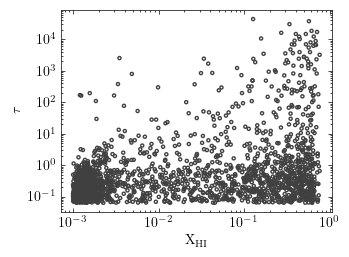

In [77]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("$\mathrm{X_{HI}}$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(neutral_fraction,optical_depth,s = 5,facecolors='none', edgecolors="0.25")
    plt.savefig('f4_uniform_40_neutral_fraction.pdf') 

In [78]:
def average_gamma(gamma):
    """
    average gamma used to calculate
    """
    average = 0
    for i in (gamma):
        average += i
    average = average/(len(gamma))
    return average
average = average_gamma(gamma)

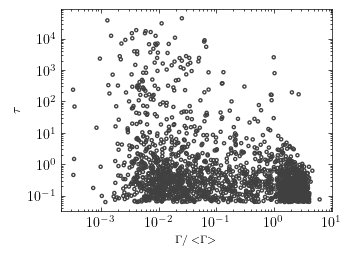

In [79]:
import matplotlib.pyplot as plt
x_along = np.linspace(min(gamma/average)-1,max(gamma/average)+5,2)
with plt.style.context('science','notebook'):
    plt.xlabel(r"$\Gamma$""$/<$"r"$\Gamma$""$>$",fontsize = 8)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(abs(gamma/average),optical_depth,s = 5,facecolors='none',edgecolors="0.25")
    plt.savefig('f7_uniform_40.pdf') 

In [80]:
checkout

[[1, 21.37743, 21.31825, 21.4288, 0.6929836256653129, 0.5882],
 [5, 25.60724, 25.57799, 25.64894, 0.07888861569370272, 0.07544],
 [7, 94.06673, 94.05204, 94.10785, 0.28022263115546875, 0.2414],
 [8, 45.33602, 45.31811, 45.3775, 0.09377572313451572, 0.04708],
 [10, 10.40144, 10.34988, 10.42437, 0.9380087915364906, 0.3664],
 [12, 58.54601, 58.53296, 58.57595, 0.0958289444316061, 0.2395],
 [13, 72.35725, 72.34326, 72.39118, 0.11860452567612798, 0.08503],
 [14, 3.15446, 3.14129, 3.19679, 0.5183484934367757, 0.01718],
 [14, 58.88882, 58.87639, 58.9312, 0.27750913581585596, 0.5576],
 [16, 65.98918, 65.97214, 66.03597, 0.4564099338591741, 0.02744],
 [17, 29.12628, 29.10856, 29.1987, 0.8592494015131859, 0.3524],
 [17, 64.61164, 64.59843, 64.63771, 0.17224576465065755, 0.07133],
 [17, 84.74833, 84.73345, 84.79238, 0.09238344726852256, 0.361],
 [19, 8.17074, 8.15121, 8.22934, 0.48525743760092466, 0.1331],
 [23, 3.72839, 3.70694, 3.76913, 0.3529079271939578, 0.006503],
 [23, 4.41293, 4.40278, 4.4

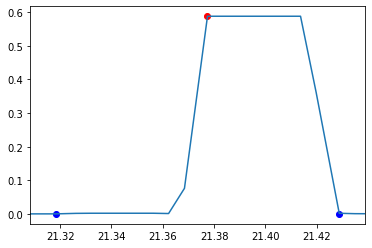

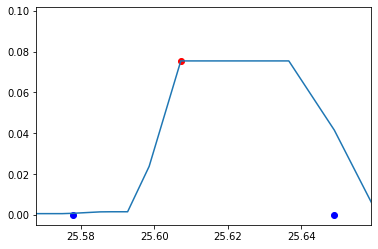

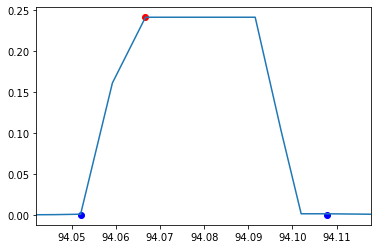

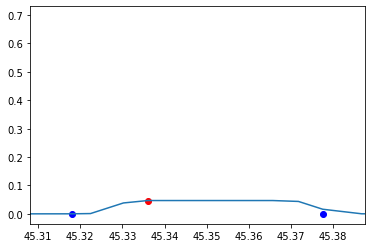

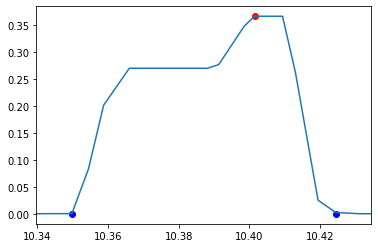

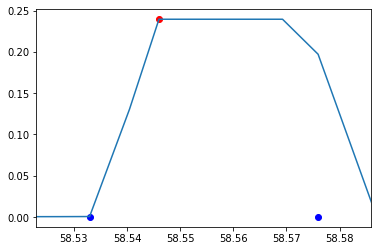

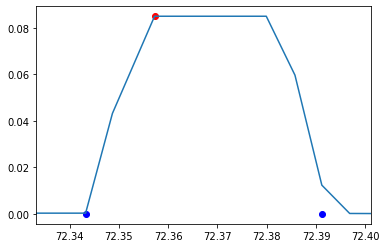

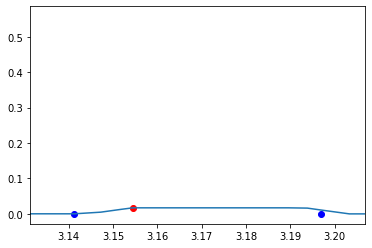

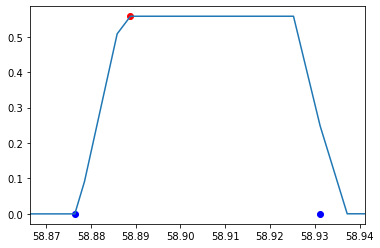

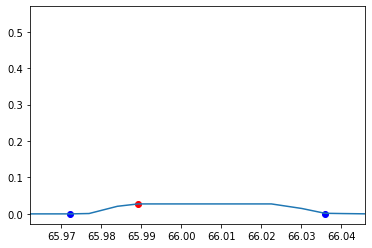

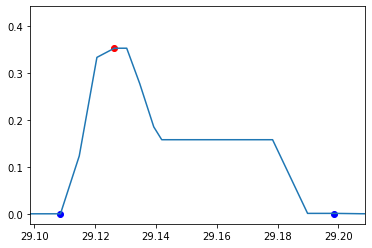

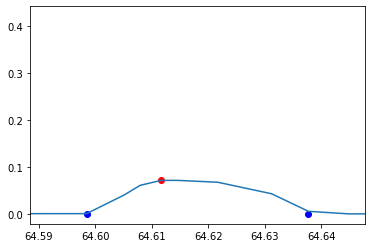

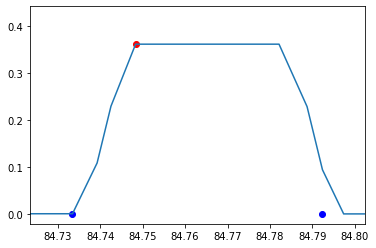

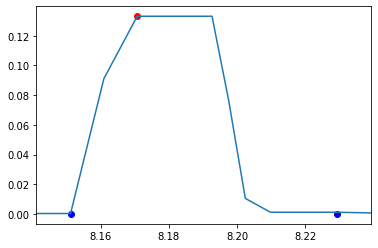

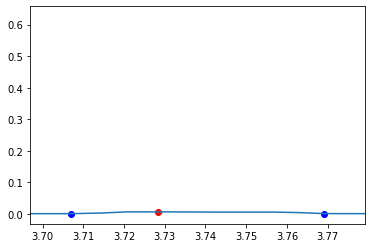

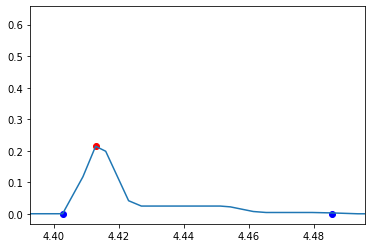

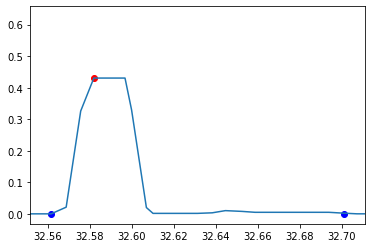

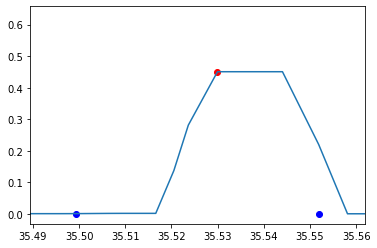

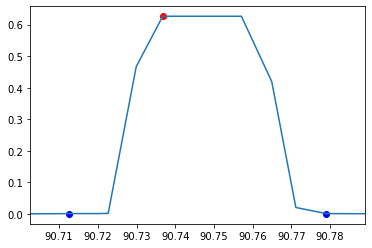

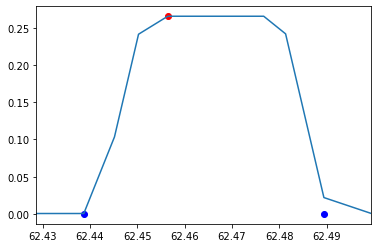

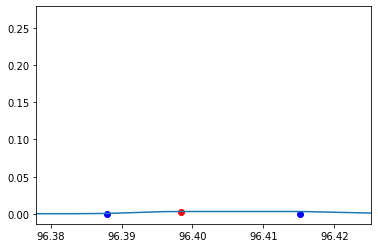

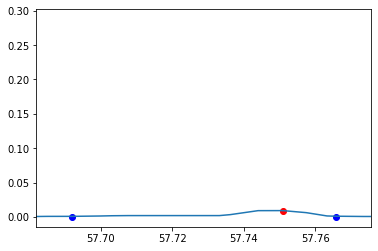

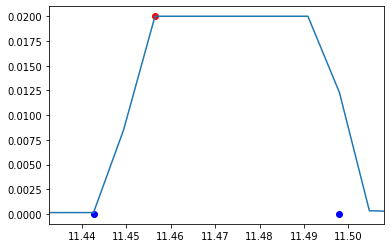

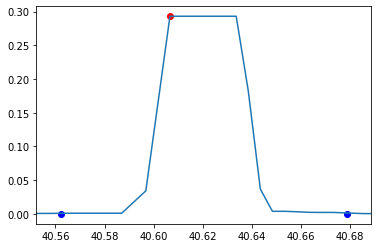

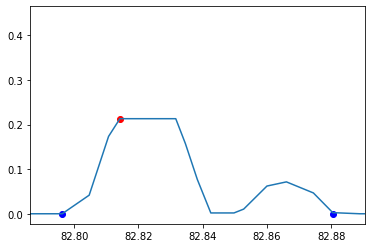

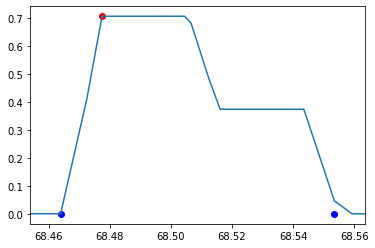

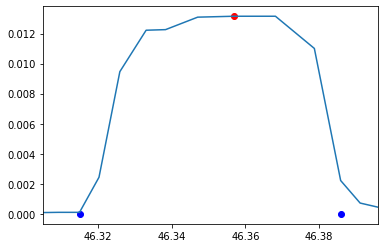

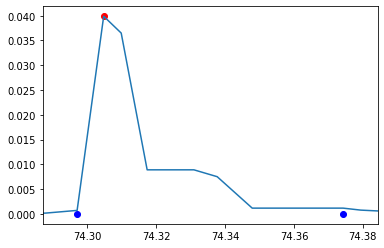

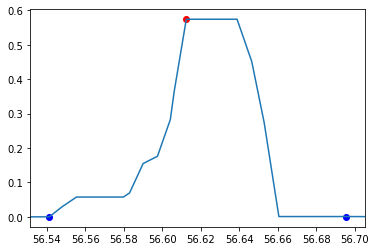

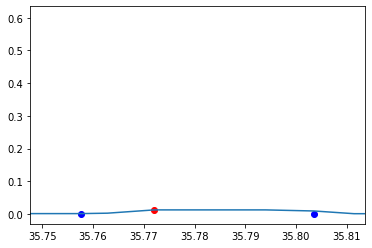

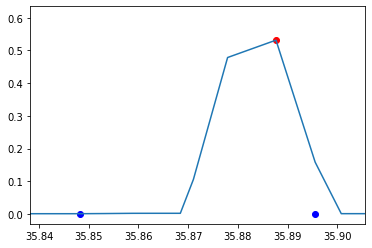

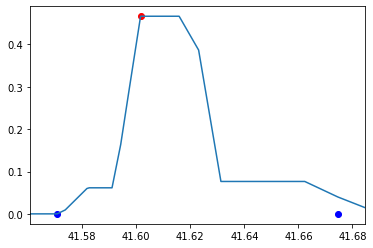

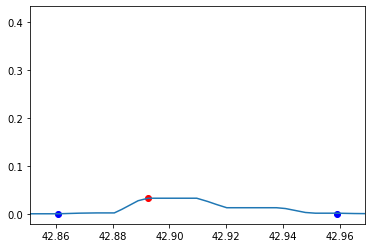

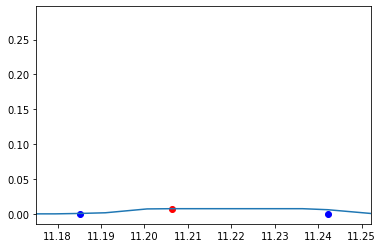

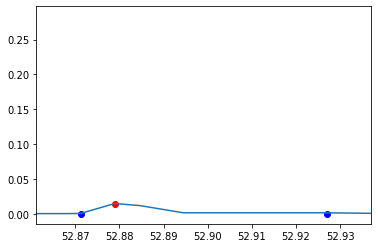

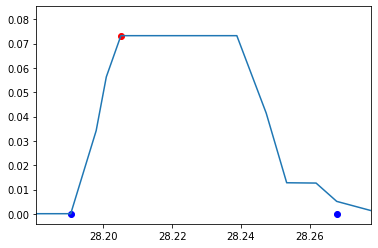

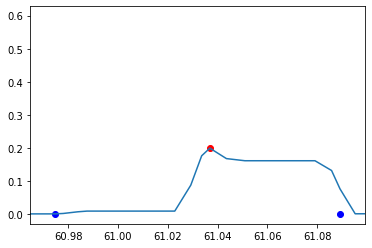

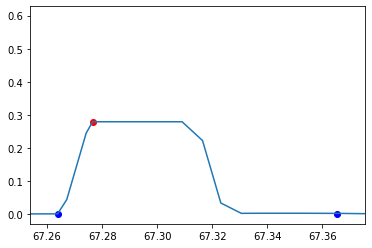

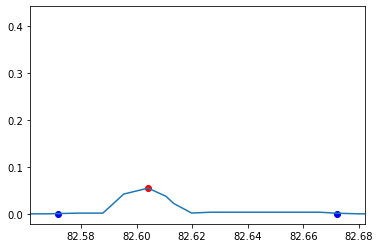

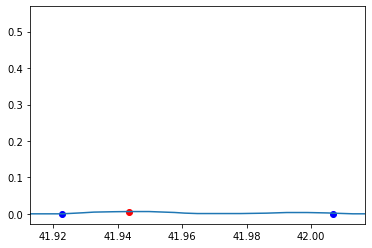

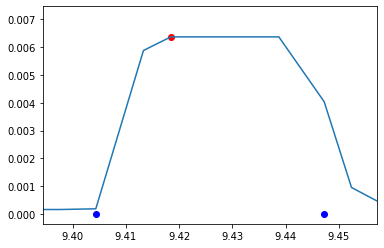

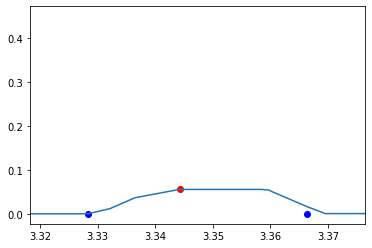

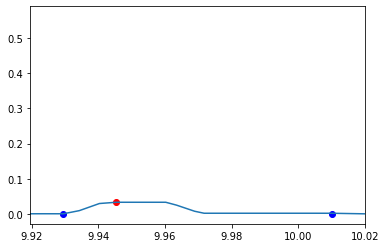

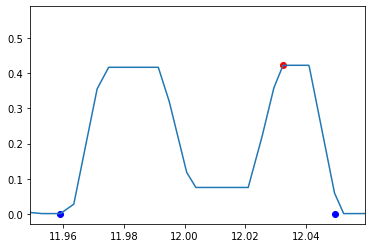

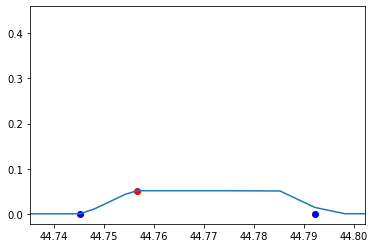

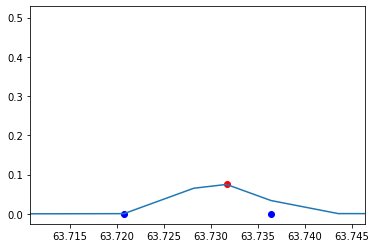

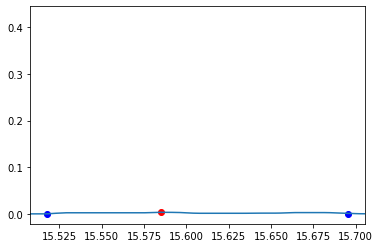

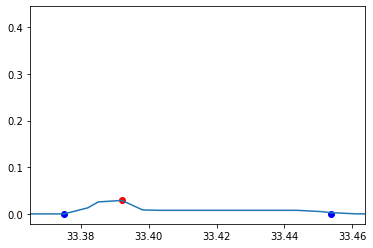

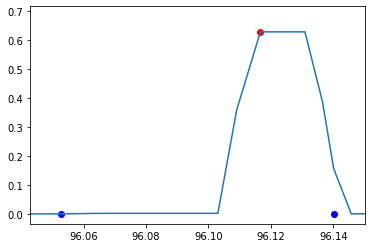

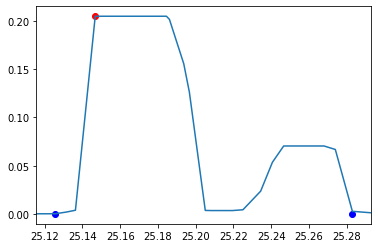

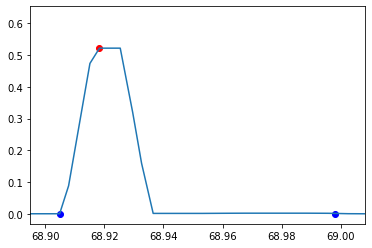

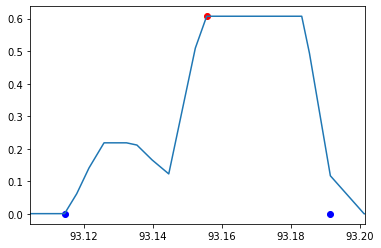

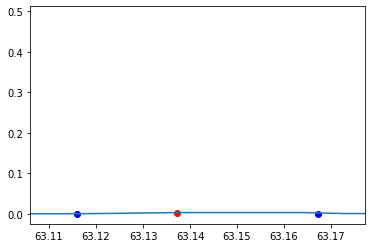

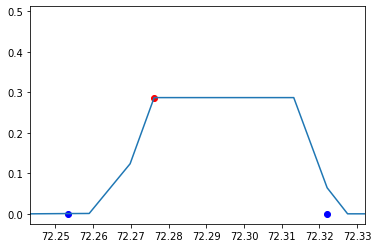

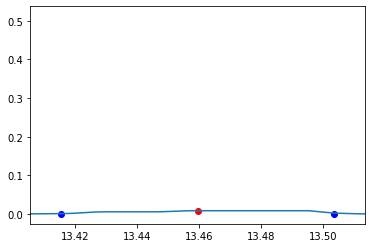

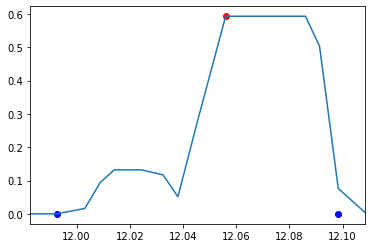

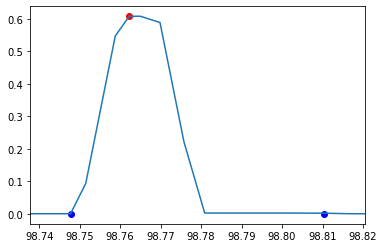

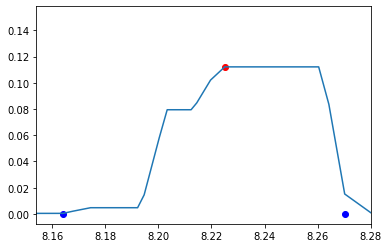

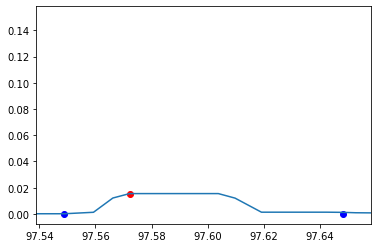

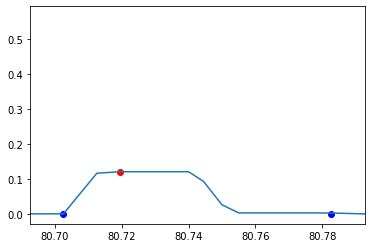

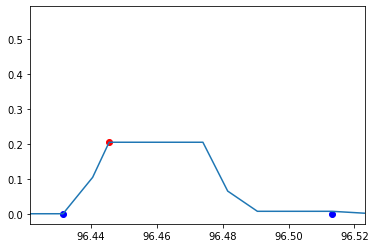

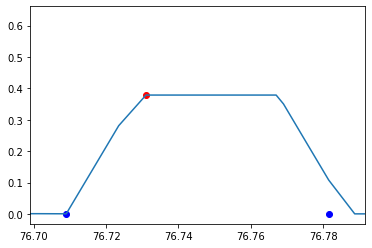

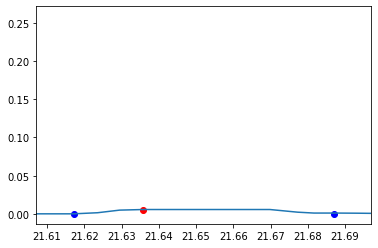

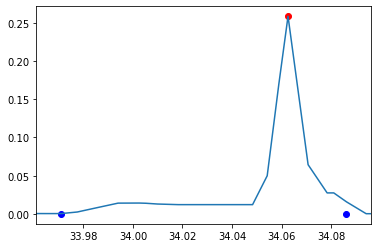

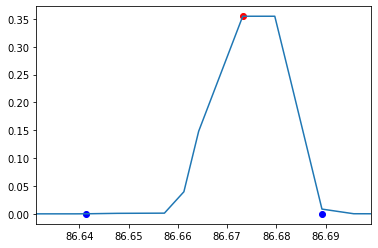

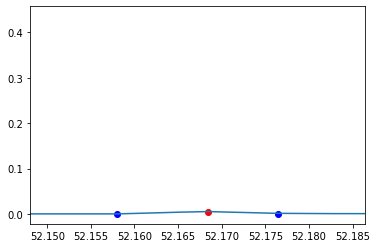

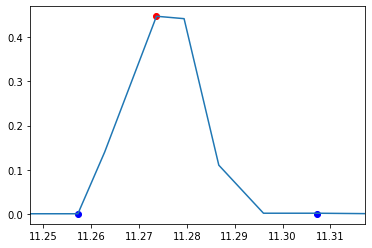

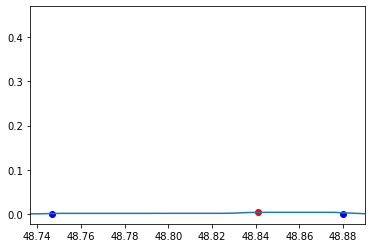

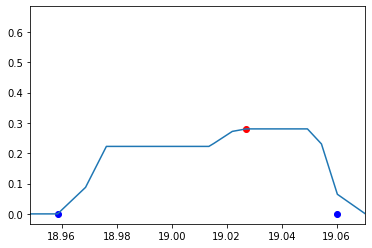

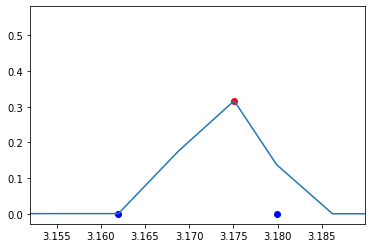

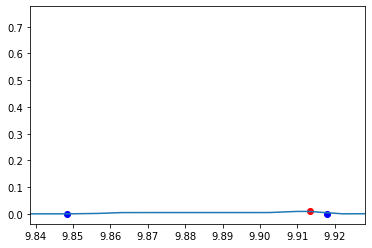

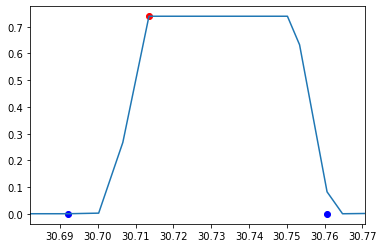

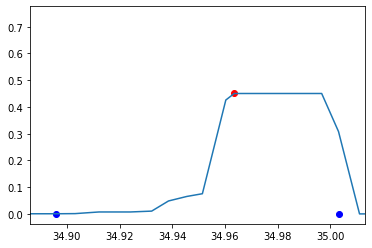

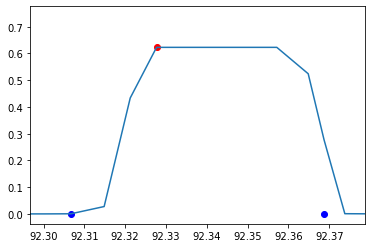

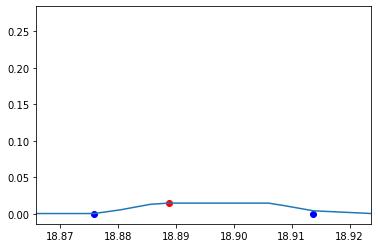

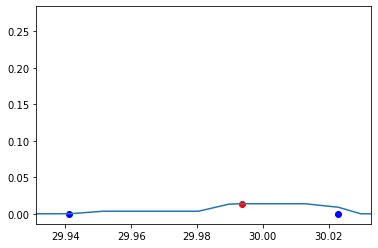

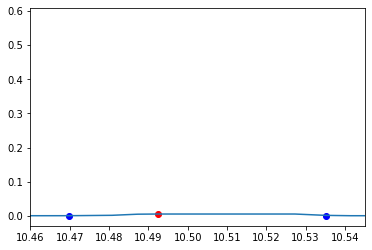

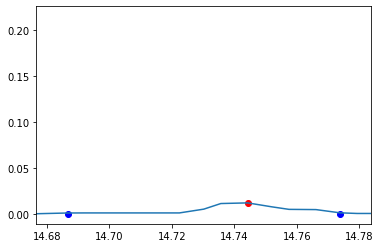

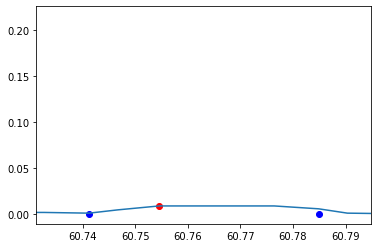

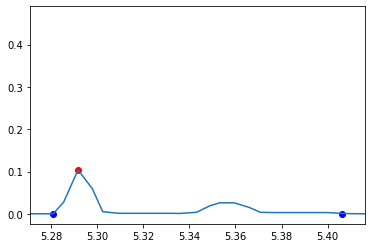

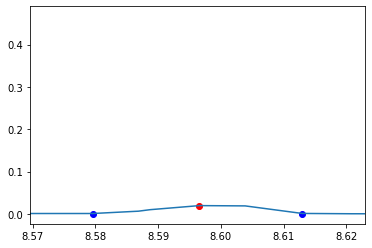

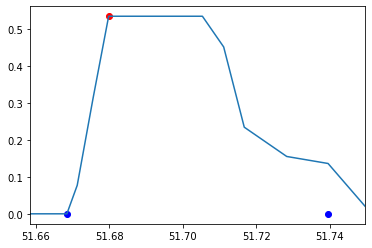

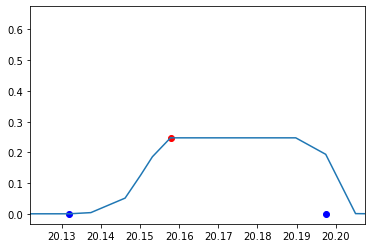

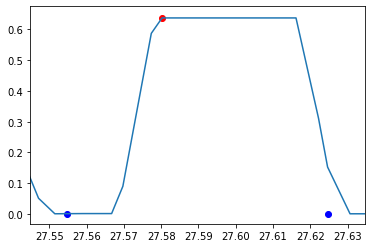

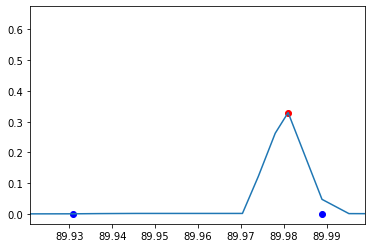

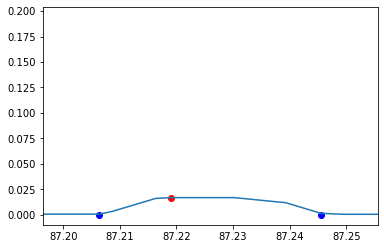

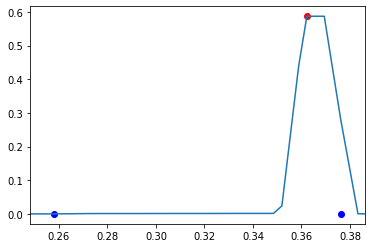

KeyboardInterrupt: 

In [86]:
for i in checkout:
    raw_path = 'los.00' + '{0:03}'.format(i[0]) +'.raw'
    den_path =  'los.00' + '{0:03}'.format(i[0]) +'.den'
    distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
    #changing the distance from chimp to cmeters
    distance1,neutral_fraction1,gas_density1,temperature1 = unPackDenFile(den_path)
    gas_density =sp.interpolate.interp1d(distance1,gas_density1, fill_value="extrapolate")(distance)
    neutral_fraction = sp.interpolate.interp1d(distance1,neutral_fraction1, fill_value="extrapolate")(distance)
    plt.plot(distance,neutral_fraction)
    plt.scatter(i[2],0,c = "blue")
    plt.scatter(i[3],0,c = "blue")
    plt.scatter(i[1],i[5],c="red")
    plt.xlim(i[2]-0.01,i[3]+0.01)
    plt.show()